### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### data structure for boe - populated with CLQ dummy data

In [4]:

test = False

if test:
    
    #### gradients in BGC
    grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
    grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
    grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
    grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

    ### mean ecosystem parameters
    mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    diatconc = 1 # mean diatom concentration (umol/L)

    ### carbonate system variables
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
    mn_SST = 2 #(oC)
    mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
    mn_DIC = 2120 # (umol/L)
    mn_TA = 2290 # (ueq/L)
    mn_pCO2 = 380 # (ppm)

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    savenam = f'{tdir}BOE-INPUT-CLQdummy.nc'
    
    data_vars = {


            ### bgc gradients
        'grad_dDICdz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFedz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFev': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'dmudFe': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'diatconc': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_SST': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_Revfact': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_DIC': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_TA': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_pCO2': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),


    }
    
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'scenario': (['scenario'], ['ssp1','ssp3']),
             }
    
    
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/make-input-nc-for-BOEcalc.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    
    ds.mn_kg[:] = mn_kg; ds.grad_dDICdz[:] = grad_dDICdz; ds.grad_DIC_surfdeep[:] = grad_DIC_surfdeep;
    ds.grad_dFedz[:] = grad_dFedz; ds.grad_dFev[:] = grad_dFev; ds.mu_L[:] = mu_L;
    ds.dmudFe[:] = dmudFe; ds.diatconc[:] = diatconc; ds.mn_SST[:] = mn_SST;
    ds.mn_Revfact[:] = mn_Revfact; ds.mn_DIC[:] = mn_DIC; 
    ds.mn_TA[:] = mn_TA; ds.mn_pCO2[:] = mn_pCO2;
    
    ds.to_netcdf(savenam)

## input netcdf for model (medusa) data

In [5]:

test = False

if test:
    
    def make_yearlist(yrst, yrend, scen):

        tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            yr = yrs[i]

            t2 = glob.glob(f'{tdir}cchem-param-medusa_scen-{scen}-{yr}.nc')
            ylist.append(t2[0])

        return ylist

    ty_1A = make_yearlist(1950,2099,'1A')
    ty_1B = make_yearlist(1950,2099,'1B')

    td_1A = xr.open_mfdataset(ty_1A)
    td_1B = xr.open_mfdataset(ty_1B)
    
    fact = 1.1
    fig, axs = plt.subplots(7,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0*2].plot(td_1A.time_counter, td_1A.mn_SST.sel({'quantity': 'mean'}), label = 'scen 1A')
    axs[1*2].plot(td_1A.time_counter, td_1A.mn_DIC.sel({'quantity': 'mean'}))
    axs[2*2].plot(td_1A.time_counter, td_1A.mn_TA.sel({'quantity': 'mean'}))
    axs[3*2].plot(td_1A.time_counter, td_1A.mn_pCO2.sel({'quantity': 'mean'}))
    axs[4*2].plot(td_1A.time_counter, td_1A.mn_Revfact.sel({'quantity': 'mean'}))
    axs[5*2].plot(td_1A.time_counter, td_1A.grad_dDICdz.sel({'quantity': 'mean'}))
    axs[6*2].plot(td_1A.time_counter, td_1A.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

    axs[0*2].plot(td_1B.time_counter, td_1B.mn_SST.sel({'quantity': 'mean'}), linestyle = ':', label = 'scen 1B')
    axs[1*2].plot(td_1B.time_counter, td_1B.mn_DIC.sel({'quantity': 'mean'}), linestyle = ':')
    axs[2*2].plot(td_1B.time_counter, td_1B.mn_TA.sel({'quantity': 'mean'}), linestyle = ':')
    axs[3*2].plot(td_1B.time_counter, td_1B.mn_pCO2.sel({'quantity': 'mean'}), linestyle = ':')
    axs[4*2].plot(td_1B.time_counter, td_1B.mn_Revfact.sel({'quantity': 'mean'}), linestyle = ':')
    axs[5*2].plot(td_1B.time_counter, td_1B.grad_dDICdz.sel({'quantity': 'mean'}), linestyle = ':')
    axs[6*2].plot(td_1B.time_counter, td_1B.grad_DIC_surfdeep.sel({'quantity': 'mean'}), linestyle = ':')

    axs[0].legend(loc = 'best')
    ylabs = ['SST \n (degC)', 'surf DIC \n umol/L', 'surf TA \n umol/L', 'surf ocean pco2 ', 'RevFact ',\
            'grad dDICdz \n umol/L/m', 'grad DIC \n (surf vs 1000m)']
    for i in range(0,7):
        axs[i*2].set_ylabel(ylabs[i])
    axs[0].set_title('yearly ts (not averaged, monthly res)')


    tvars = ['mn_SST','mn_DIC','mn_TA','mn_pCO2','mn_Revfact',\
           'grad_dDICdz','grad_DIC_surfdeep']
    for i in range(0,7):

        axs[i*2+1].plot(td_1A.time_counter.groupby('time_counter.year').mean(),\
                        td_1A[tvars[i]].sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                        color = 'k', label = 'scen 1A')
        axs[i*2+1].plot(td_1A.time_counter.groupby('time_counter.year').mean(),\
                        td_1B[tvars[i]].sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                        color = 'k', linestyle = ':', label = 'scen 1B')
        cols = ['r','g','b','y']
        seas = ['DJF','MAM','JJA','SON']
        for c in range(0,4):
            axs[i*2+1].plot(td_1A.time_counter.sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                            .groupby('time_counter.year').mean(),\
                            td_1A[tvars[i]].sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                            .sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                            color = cols[c], label = f'scen 1A, {seas[c]}')
            axs[i*2+1].plot(td_1A.time_counter.sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                            .groupby('time_counter.year').mean(),\
                            td_1B[tvars[i]].sel({'quantity': 'mean'}).sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                            .groupby('time_counter.year').mean(),
                            color = cols[c], linestyle = ':', label = f'scen 1B, {seas[c]}')
    axs[1].legend(ncol = 3, fontsize = 10, loc = 'best')# bbox_to_anchor = [1,1])        
    plt.tight_layout()
    
    ####
    #### gradients in BGC
#     grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
#     grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
    grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
    grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

    ### mean ecosystem parameters
    mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    diatconc = 1 # mean diatom concentration (umol/L)

    ### carbonate system variables
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
#     mn_SST = 2 #(oC)
#     mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
#     mn_DIC = 2120 # (umol/L)
#     mn_TA = 2290 # (ueq/L)
#     mn_pCO2 = 380 # (ppm)

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    savenam = f'{tdir}BOE-INPUT-medusamodel.nc'
    print(savenam)
    
    data_vars = {


            ### bgc gradients
        'grad_dDICdz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFedz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFev': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'dmudFe': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'diatconc': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_SST': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_Revfact': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_DIC': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_TA': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_pCO2': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),


    }
    
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'scenario': (['scenario'], ['ssp1','ssp3']),
             }
    
    
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/make-input-nc-for-BOEcalc.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    
    ds.mn_kg[:] = mn_kg; 
    ds.grad_dFedz[:] = grad_dFedz; ds.grad_dFev[:] = grad_dFev; ds.mu_L[:] = mu_L;
    ds.dmudFe[:] = dmudFe; ds.diatconc[:] = diatconc;
    
#     ds.grad_dDICdz[:] = grad_dDICdz; ds.grad_DIC_surfdeep[:] = grad_DIC_surfdeep;
#     ds.mn_SST[:] = mn_SST;
#     ds.mn_Revfact[:] = mn_Revfact; ds.mn_DIC[:] = mn_DIC; 
#     ds.mn_TA[:] = mn_TA; ds.mn_pCO2[:] = mn_pCO2;
    
    ### for this stuff we have data from the model
    
    scenarioar = ['ssp1','ssp3']
    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']

    for p in periodar:
        ind = 0 
        tpe = int(p[0:4])
        for s in seasonar:
            for sc in scenarioar:

                print(f'{p} (starts {tpe}), {s}, {sc}')


                if sc == 'ssp1': td = td_1A;
                if sc == 'ssp3': td = td_1B;
                td = td.sel(time_counter=slice(f'{tpe}-01-01', f'{tpe+49}-12-31'))

                if s == 'FY':
                    td = td.groupby('time_counter.year').mean()
                else:
                    td = td.sel(time_counter=(td['time_counter.season'] == s)).\
                    groupby('time_counter.year').mean()

#                 mn_pCO2 = td.mn_pCO2[:,0].mean().values; 
#                 grad_dDICdz = td.grad_dDICdz[:,0].mean().values;
                #mn_Revfact = td.mn_Revfact[:,0].mean().values; 
#                 grad_DIC_surfdeep = td.grad_DIC_surfdeep[:,0].mean().values;
#                 mn_DIC = td.mn_DIC[:,0].mean().values; 
    
                ds.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_pCO2[:,0].mean().values; 
                ds.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }] = td.grad_dDICdz[:,0].mean().values; 
                ds.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_Revfact[:,0].mean().values; 
                ds.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }] = td.grad_DIC_surfdeep[:,0].mean().values; 
                ds.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_DIC[:,0].mean().values; 
                ds.mn_TA.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_TA[:,0].mean().values; 
                ds.mn_SST.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_SST[:,0].mean().values; 
            
    ds.to_netcdf(savenam)

In [6]:

def plot_vars_cchem(ds, tcolor = 'r', dsname = ''):


    tvars = [
             'grad_DIC_surfdeep','grad_DIC_surfdeep','grad_DIC_surfdeep',
                'grad_dDICdz','grad_dDICdz','grad_dDICdz',
                'mn_Revfact','mn_Revfact','mn_Revfact',
               'mn_DIC','mn_DIC','mn_DIC',
               'mn_pCO2','mn_pCO2','mn_pCO2']
    
    per = ['1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',]
    
    for i in range(0,15):
        
        ssp1 = ds[tvars[i]].loc[{'period': per[i], 'scenario': 'ssp1' }] 
        ssp3 = ds[tvars[i]].loc[{'period': per[i], 'scenario': 'ssp3' }] 


        axs[i].plot(ssp1.season,ssp1.values, color = tcolor, marker = 'o', linewidth = 0,\
                   label = f'{dsname}, ssp1')
        axs[i].plot(ssp1.season,ssp3.values, color = tcolor, marker = 'x', linewidth = 0,\
                   label = f'{dsname}, ssp3')
        axs[i].set_title(f'{tvars[i]} {per[i]}')
        axs[2].legend(bbox_to_anchor = [1,1])

    plt.suptitle('CChem parameters for input into BOE')

def plot_vars_bio(ds, tcolor = 'r', dsname = ''):



    tvars = ['mu_L','mu_L','mu_L',
           'grad_dFedz','grad_dFedz','grad_dFedz',
           'grad_dFev','grad_dFev','grad_dFev',
           'dmudFe','dmudFe','dmudFe',
           'diatconc','diatconc','diatconc',
           'mn_kg','mn_kg','mn_kg',
           'mn_SST','mn_SST','mn_SST',
           ]
    

    per = ['1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',
           '1950-2000','2000-2050','2050-2100',]
    
    for i in range(0,21):
        
        ssp1 = ds[tvars[i]].loc[{'period': per[i], 'scenario': 'ssp1' }] 
        ssp3 = ds[tvars[i]].loc[{'period': per[i], 'scenario': 'ssp3' }] 


        axs[i].plot(ssp1.season,ssp1.values, color = tcolor, marker = 'o', linewidth = 0,\
                   label = f'{dsname}, ssp1')
        axs[i].plot(ssp1.season,ssp3.values, color = tcolor, marker = 'x', linewidth = 0,\
                   label = f'{dsname}, ssp3')
        axs[i].set_title(f'{tvars[i]} {per[i]}')
        axs[2].legend(bbox_to_anchor = [1,1])

    plt.suptitle('Biological parameters and SST for input into BOE')
                         


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


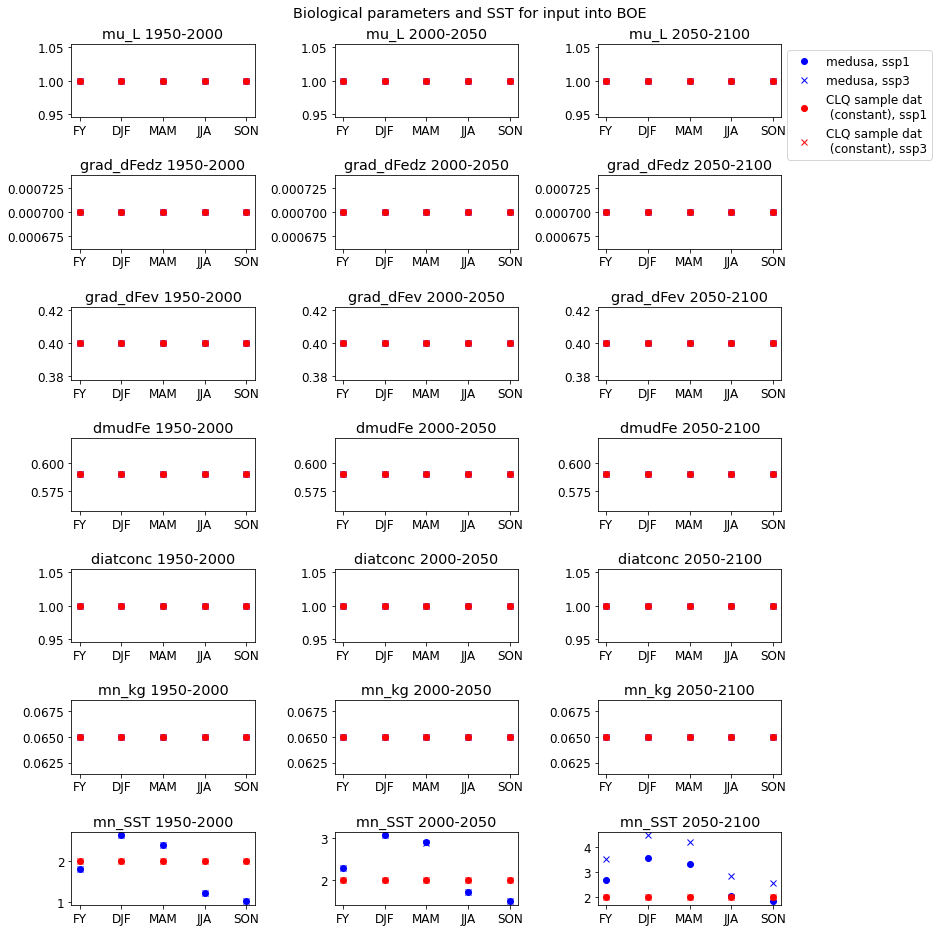

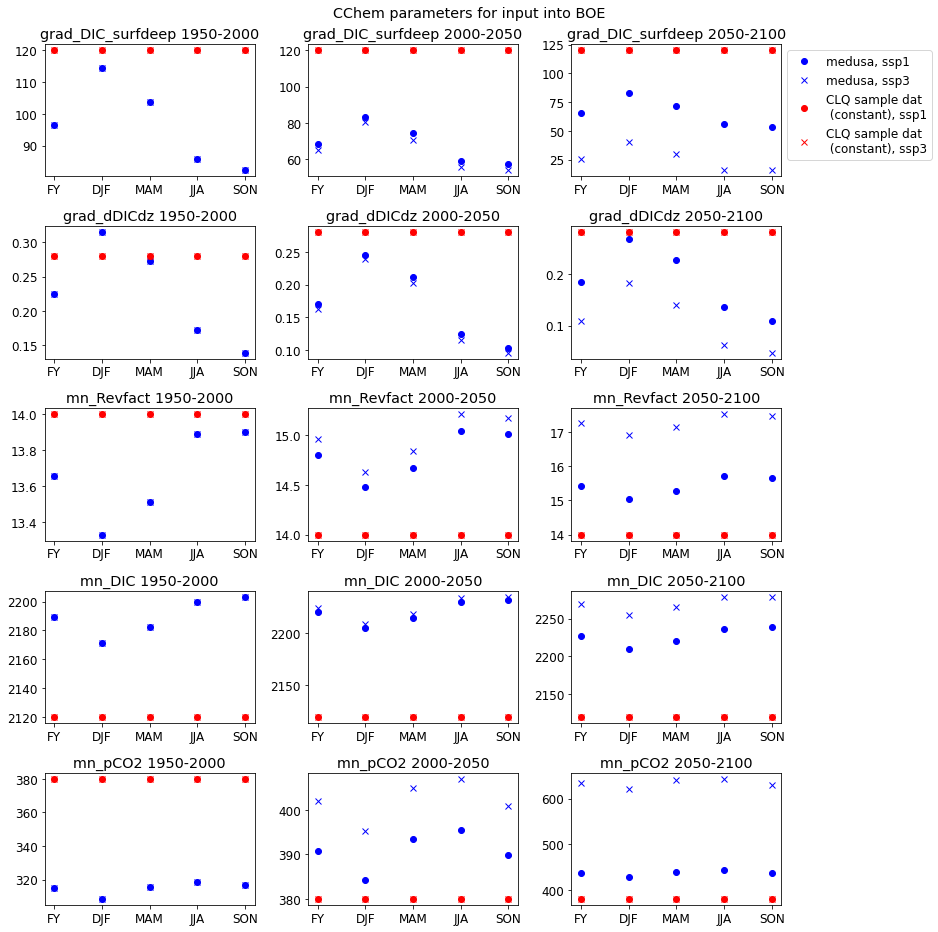

In [7]:
w = xr.open_dataset('./data/BOE-INPUT-medusamodel.nc')

w2 = xr.open_dataset('./data/BOE-INPUT-CLQdummy.nc')

fact = 1.1
fig, axs = plt.subplots(7,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
plot_vars_bio(w, 'b', 'medusa')
plot_vars_bio(w2, 'r', 'CLQ sample dat \n (constant)')
plt.tight_layout()


fact = 1.1
fig, axs = plt.subplots(5,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
plot_vars_cchem(w, 'b', 'medusa')
plot_vars_cchem(w2, 'r', 'CLQ sample dat \n (constant)')
plt.tight_layout()

## making observational data - diatoms


need this data in umol/ L (presumably umol C/L)

### maredat and pangea

Text(0, 0.5, 'umol C/L')

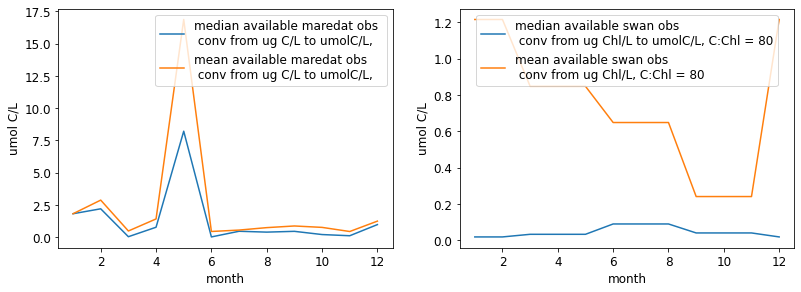

In [8]:
w2 = xr.open_dataset('./data/pigment_type_mld_seasonal_climatology_absolute_tchla.nc')
#https://doi.pangaea.de/10.1594/PANGAEA.855412
    
swandat_meddiat = np.arange(1,13).astype(float)
swandat_meandiat = np.arange(1,13).astype(float)
for i in range(0,4):
    
    q = w2.abs_tchla.isel(lat = slice(-90,-50), season = i) 
    diat =  q[:,:,7].values
    q2 = ~np.isnan(diat)
    rv = diat[q2]
    startind = i*3
    endind = i*3+3
    swandat_meddiat[i*3:i*3+3] = np.median(rv) * 80/12 #80 gC to 1 gChl , 1 mol is 12 g?
    swandat_meandiat[i*3:i*3+3] = np.mean(rv)* 80/12 
swandat_meddiat = np.roll(swandat_meddiat, -1)
swandat_meandiat = np.roll(swandat_meandiat, -1)

w = xr.open_dataset('/gpfs/scratch/e031/Data/Maremip/MarEDat20120716Diatoms.nc', decode_times = False)

### i assume this is in ug CARBON?

mos = np.arange(1,13)
maredat_meddiat = np.arange(1,13).astype(float)
maredat_meandiat = np.arange(1,13).astype(float)

for i in range(0,12):
    q = w.BIOMASS.isel(LATITUDE = slice(-90,-50), DEPTH = 0, TIME = i).values
    q2 = ~np.isnan(q)
    rv = q[q2]
    maredat_meddiat[i] = np.median(rv)/12 #from ug to umol
    maredat_meandiat[i] = np.mean(rv)/12 
    
fig, axs = plt.subplots(1,2, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')

axs[0].plot(mos,maredat_meddiat, label = 'median available maredat obs \n conv from ug C/L to umolC/L,')
axs[0].plot(mos,maredat_meandiat, label = 'mean available maredat obs \n conv from ug C/L to umolC/L,')
axs[0].legend(loc = 'best')

axs[1].plot(mos,swandat_meddiat, label = 'median available swan obs \n conv from ug Chl/L to umolC/L, C:Chl = 80')
axs[1].plot(mos,swandat_meandiat, label = 'mean available swan obs \n conv from ug Chl/L, C:Chl = 80')
axs[1].legend(loc = 'best')

axs[0].set_xlabel('month')
axs[0].set_ylabel('umol C/L')
axs[1].set_xlabel('month')
axs[1].set_ylabel('umol C/L')



## medusa data


Text(0.5, 0.98, 'SO south of -50 iron and phytoplankton, medusa, 1 month, 20090301')

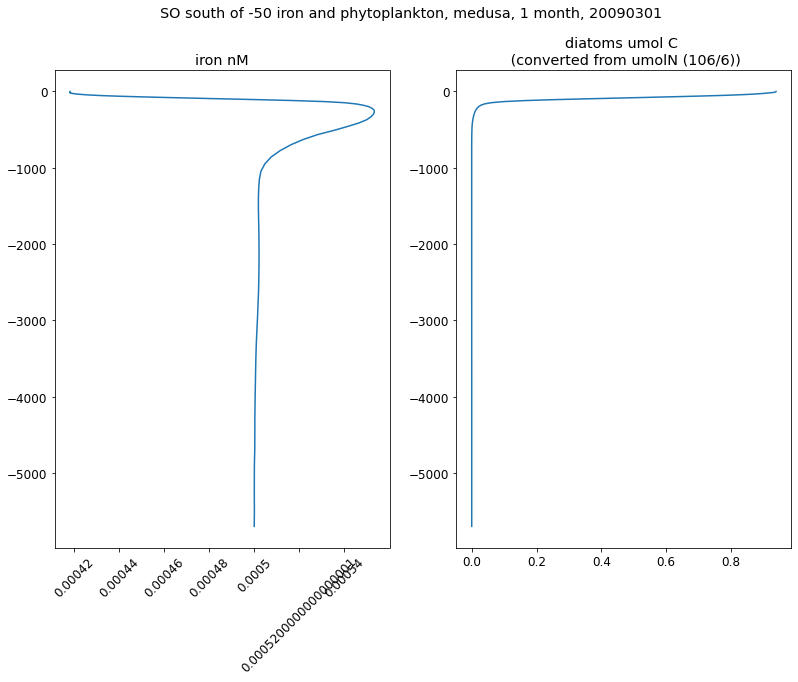

In [131]:
tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/oneyear2009ukesm/'
med = xr.open_dataset(f'{tdir}medusa_bc370o_1m_20090301-20090401_ptrc-T.nc')
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask.nc')

tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

fer_dp = med.FER.isel(y=slice(0,114)).weighted(tmesh['csize'].sel(y=slice(0,114))).mean(dim = ['x','y'])
PHD_dp = med.PHD.isel(y=slice(0,114)).weighted(tmesh['csize'].sel(y=slice(0,114))).mean(dim = ['x','y'])*106/16

med
fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs[0].plot(fer_dp[0,:],-fer_dp.deptht[:])
axs[0].set_xticklabels(axs[0].get_xticks(), rotation=45)
axs[1].plot(PHD_dp[0,:],-fer_dp.deptht[:])

axs[0].set_title('iron nM')
axs[1].set_title('diatoms umol C \n (converted from umolN (106/6))')
fig.suptitle('SO south of -50 iron and phytoplankton, medusa, 1 month, 20090301')

## observational data, iron

In [66]:
file_path = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/tagliabue_fe_database_jun2015_public.xlsx'
df = pd.read_excel(file_path, skiprows=3, header=None)  # by name

new_df = df.iloc[2:]
new_df.rename(columns={0: 'month'}, inplace=True) 
new_df.rename(columns={1: 'year'}, inplace=True) 
new_df.rename(columns={2: 'lon'}, inplace=True) 
new_df.rename(columns={3: 'lat'}, inplace=True) 
new_df.rename(columns={4: 'depth'}, inplace=True) 
new_df.rename(columns={5: 'dFe'}, inplace=True) 

SO_df = new_df[new_df['lat'] <= -50]
SO_df['month'] = SO_df['month'].astype(int)

lons = SO_df.lon.to_numpy()
lats = SO_df.lat.to_numpy()
mons = SO_df.month.to_numpy()
ids = np.zeros_like(lats)
seas = np.zeros_like(lats)

ulon = np.unique(lons)
uid = 1
for i in range(0,len(ulon)):
    tlon = ulon[i]
    wlon = np.where(lons == tlon)
    corlat = lats[wlon]
    ucorlat = np.unique(corlat)
    #print(f'lon {tlon}, corlat = {ucorlat}')
    for j in range(0,len(ucorlat)):
        
        tlat = ucorlat[j]
        wlat = np.where((lons == tlon) & (lats == tlat))
        cormo = mons[wlat]
        ucormo = np.unique(cormo)
        for k in range(0,len(ucormo)):
            tmo = ucormo[k]
            wid = np.where((lons == tlon) & (lats == tlat) & (mons == tmo))
            ids[wid] = uid
            uid = uid +1 
    
mons = SO_df.month.to_numpy()
for i in range(0, len(mons)):
    tmo = mons[i]
    if ((tmo == 1) | (tmo == 2) | (tmo == 12)): seas[i] =1
    if ((tmo == 3) | (tmo == 4) | (tmo == 5)): seas[i] =2
    if ((tmo == 6) | (tmo == 7) | (tmo == 8)): seas[i] =3
    if ((tmo == 9) | (tmo == 10) | (tmo == 11)): seas[i] =4
        
print(np.nanmin(seas))
print(uid-1)
# print(lens)
SO_df['uid'] = ids
SO_df['seas'] = seas
##



1
491


In [84]:
SO_df = SO_df[SO_df['dFe'] >= 0]

SO_df

,month,year,lon,lat,depth,dFe,6,uid,seas
138,2,1999,140,-61,0,0.08,"Bowie, A.R., M.T. Maldonado, R.D. Frew, P.L. C...",335,1
139,1,1999,140,-61,10,0.05,"Boyd, P.W. and 34 others, 2000. A mesoscale p...",334,1
140,1,1999,140,-61,10,0.11,"Boyd, P.W. and 34 others, 2000. A mesoscale p...",334,1
141,1,1999,140,-61,10,0.08,"Boyd, P.W. and 34 others, 2000. A mesoscale p...",334,1
225,4,1999,18.5,-60,20,0.18,"Boye, M., C.M.G. van den Berg, J.T.M. de Jong,...",261,2
...,...,...,...,...,...,...,...,...,...
18648,1,2014,165.398,-64.2863,55.536,0.034,"Gerringa, L. J. A., P. Laan, G. L. van Dijken,...",375,1
18649,1,2014,165.398,-64.2863,76.415,0.047,"Gerringa, L. J. A., P. Laan, G. L. van Dijken,...",375,1
18650,1,2014,165.398,-64.2863,111.413,0.174,"Gerringa, L. J. A., P. Laan, G. L. van Dijken,...",375,1
18651,1,2014,165.398,-64.2863,202.883,0.201,"Gerringa, L. J. A., P. Laan, G. L. van Dijken,...",375,1


406 not found
409 not found
411 not found
444 not found
452 not found
455 not found
466 not found


Text(0.5, 0.98, 'SO (south of -50) iron database, Tagliabue 2015 (raw)')

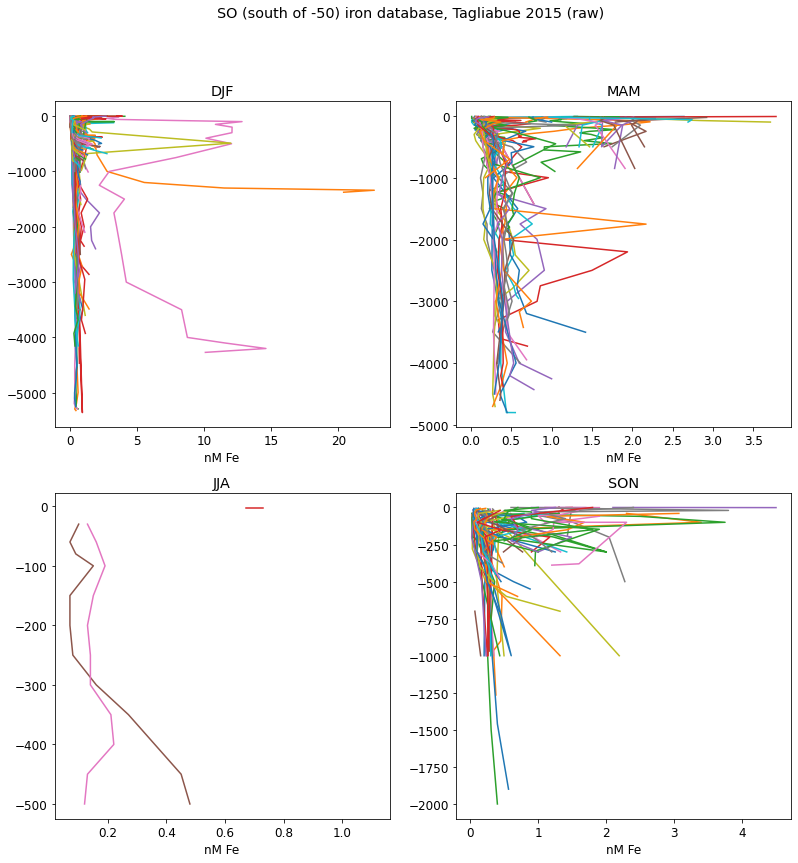

In [88]:
fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(1,492):
    
    try:
        sel = SO_df[SO_df['uid']==i]
        tseas = (sel.seas.to_numpy()[0])
        tax = tseas - 1
        axs[tax].plot(sel.dFe, -sel.depth)
#         print(i)
#         print(sel.depth.values)
#         print(sel.dFe.values)
#         print()
    except:
        print(f'{i} not found')
       
tits = ['DJF','MAM','JJA','SON']
for i in range(0,4):
    axs[i].set_title(tits[i])
    axs[i].set_xlabel('nM Fe')
    
plt.suptitle('SO (south of -50) iron database, Tagliabue 2015 (raw)')

290
11


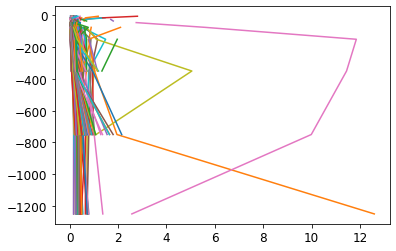

In [113]:
from scipy.interpolate import interp1d
sel = SO_df[SO_df['seas']==1]
ids = np.unique(sel.uid.to_numpy())
print(len(ids))

depths = np.array([0,10,20,30,40,50,100,200,500,1000,1500])
depths2 = np.array([5,15,25,35,45,75,150,350,750,1250])


print(len(depths))

int_prof = np.zeros([len(ids),10])

ind = 0 
for i in ids:
    
    sel2 = sel[sel['uid']==i]
    axs[tax].plot(sel2.dFe, -sel2.depth)
    
    
    x = sel2.dFe.to_numpy().astype('float')
    y = sel2.depth.to_numpy().astype('float')
    
    for d in range(0,len(depths)-1):
        tloc = np.where((y>=depths[d]) & (y<depths[d+1]))
        int_prof[ind,d] = np.nanmean(x[tloc])
    ind = ind+1
    
plt.figure()
for i in range(0, len(ids)):
    plt.plot(int_prof[i,:],-depths2)

492


In [46]:
sel = SO_df[SO_df['uid'] == 1]

1, ['12']
2, [1]
3, [1]
4, [1]
5, [12]
6, [1]
7, [1]
8, [10]
9, ['1']
10, [1]
11, ['1']
12, [1]
13, [1]
14, [1]
15, ['11']
16, [12]
17, [1]
18, [11]
19, [12]
20, [12]
21, [12]
22, [11]
23, [12]
24, [1]
25, [12]
26, [1]
27, [11]
28, ['1']
29, [1]
30, [1]
31, [1]
32, [1]
33, [1]
34, [1]
35, [10]
36, [11]
37, [1]
38, [11]
39, [1]
40, [11]
41, [1]
42, [11]
43, [11]
44, [1]
45, [11]
46, [1]
47, [11]
48, [12]
49, [12]
50, [11]
51, [12]
52, [12]
53, ['1']
54, [12]
55, [12]
56, [12]
57, [12]
58, [12]
59, [12]
60, [12]
61, [12]
62, [12]
63, [12]
64, [2]
65, [12]
66, [2]
67, [1]
68, [1]
69, [1]
70, [2]
71, [2]
72, [12]
73, [2]
74, [1]
75, [2]
76, [1]
77, [1]
78, [1]
79, [1]
80, [1]
81, [1]
82, [1]
83, [1]
84, [1]
85, [1]
86, [1]
87, [1]
88, [1]
89, [1]
90, [12]
91, [4]
92, [3]
93, [3]
94, [4]
95, [3]
96, [12]
97, [3]
98, [4]
99, [4]
100, [4]
101, [3]
102, [12]
103, [4]
104, [3]
105, [4]
106, [4]
107, [4]
108, [3]
109, [3]
110, [4]
111, [4]
112, [4]
113, [4]
114, [12]
115, [12]
116, [4]
117, [12]

In [52]:
SO_df['month'] = SO_df['month'].astype(int)